### Research Process 


#### Init Libraries

In [1]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import os

#### Load Dataset and split into Features and Label

In [2]:
#load data
df=pd.read_csv("breast-cancer-wisconsin-data/data.csv")
#drop irelevent columns for the classification
df = df.drop(columns=['Unnamed: 32', 'id'])
# rearange the data for X - featuers and Y leabels 
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

#### Encode Labels

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)

#### The mapping of the labels

In [4]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'B': 0, 'M': 1}


#### Splitting the data into Train, Test and Valid datasets

In [5]:
#split the data
from sklearn.model_selection import train_test_split
XData_train_val, XData_test, ydata_train_val, ydata_test = train_test_split(X, y, test_size=0.2, random_state=0)
XData_train, XData_val, ydata_train, ydata_val = train_test_split(XData_train_val, ydata_train_val, test_size=0.2, random_state=0)

#### Scale the data

In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(XData_train)
X_test = scaler.transform(XData_test)
X_val = scaler.transform(XData_val)

X_train_val = XData_train_val.values

y_train = ydata_train
y_test = ydata_test
y_val = ydata_val

y_train_val = ydata_train_val

#### Handling the imbalance between the classes

In [7]:
#handling imbalance data 
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
#the class weight is done only on the train data to impact the learning process and to evaluete beter the model proformence
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.774468085106383, 1: 1.4108527131782946}

as predicted the minorty class 'M'=1 gets higher weight of 1.368

### Neural Networks

##### Init Libraries

In [8]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.regularizers import l1, l2
#from keras.layers import Dropout, Flatten, BatchNormalization
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks
from keras import utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf

##### Function Helpers

In [9]:
def model_result(model):
    print('================================================================================')
    print(f'Evaluation Report for Model: {model.name}')

    # accuracy
    result = model.evaluate(X_test, y_test, verbose=0)        
    print(f'Loss Value: {result[0]:.3f}, Accuracy: {result[1]*100:.3f}%')

    # confusion matrix
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.round(y_prob).astype(int)    
    cm_test = confusion_matrix(y_test, y_pred)    
    #sns.heatmap(cm_test,annot=True)
    cm_disp = ConfusionMatrixDisplay(cm_test, display_labels=le.classes_)
    cm_disp.plot()
    plt.show()

    # classification report
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)

    print('Model Summary:')
    print(model.summary())
    print('================================================================================')

In [10]:
def model_history(history, param=None):
    plt.figure(figsize=(15,6))

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    if param is None:
        plt.title('Train and Validation Loss')
    else:
        plt.title(f'Train and Validation Loss on {param}')

    plt.plot(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], 'r*', label='Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_loss'][val_loss_min_pos]:.3f})', va='bottom')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], 'r*', label='Validation Accuracy @ Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_accuracy'][val_loss_min_pos]:.3f})', va='bottom')

    if param is None:
        plt.title('Train and Validation Accuracy')
    else:
        plt.title(f'Train and Validation Accuracy on {param}')
        
    plt.legend()

    plt.show()    

In [11]:
def proc_history(history):

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    train_acc = history.history['accuracy'][val_loss_min_pos]
    train_loss = history.history['loss'][val_loss_min_pos]

    val_acc = history.history['val_accuracy'][val_loss_min_pos]
    val_loss = history.history['val_loss'][val_loss_min_pos]    

    val_recall = history.history['val_recall'][val_loss_min_pos]

    return {'Train Accuracy': train_acc, 'Train Loss': train_loss, 'Validation Accuracy': val_acc, 'Validation Loss': val_loss, 'Validation Recall': val_recall}

In [12]:
def model_fit(model, optimizer=optimizers.RMSprop, learning_rate=0.001, epochNum=2500, batchSize=32, en_reduce_lr=False, en_early_stopping=True, pca=False, verbose="auto", Dataset=None):      
    
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=0)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=0)
    checkpoint_filepath = f'model_checkpoints/{model.name}_checkpoint.model.keras'
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0)
    
    callbacks_list = [model_checkpoint_callback]

    if en_reduce_lr:
        callbacks_list.append(reduce_lr)

    if en_early_stopping:
        callbacks_list.append(early_stopping)

    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', metrics.Recall(name='recall')])
    if Dataset is None:
        history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epochNum, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)
    else:
        history = model.fit(Dataset['X_train'], Dataset['y_train'], batch_size=batchSize, epochs=epochNum, validation_data=(Dataset['X_val'], Dataset['y_val']), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)

    model = models.load_model(checkpoint_filepath)

    return history, model

In [13]:
def model_kfold(xtrain, ytrain, model_base, optimizer=optimizers.RMSprop,learning_rate=0.001, epochNum=2500, batchSize=32, en_reduce_lr=False, en_early_stopping=True, verbose="auto"):
    model = models.clone_model(model_base)
    fold_k = StratifiedKFold(n_splits = 5).split(xtrain, ytrain)
    
    result_df = pd.DataFrame(columns=['k', 'Train Accuracy', 'Train Loss' , 'Validation Accuracy', 'Validation Loss',  'Validation Recall'])
    for k , (train, valid) in enumerate(fold_k):

        scaler = RobustScaler()

        X_train = scaler.fit_transform(xtrain[train])
        X_val = scaler.transform(xtrain[valid])
        
        dataset = {'X_train': X_train, 'y_train': ytrain[train], 'X_val': X_val, 'y_val': ytrain[valid]}
        model.set_weights(model_base.get_weights())

        

        history, model = model_fit(model, optimizer=optimizer, learning_rate=learning_rate, epochNum=epochNum, batchSize=batchSize, en_reduce_lr=en_reduce_lr, en_early_stopping=en_early_stopping, Dataset=dataset, verbose=verbose)    
        
        proc_data = proc_history(history)

        new_row = {'k': k, **proc_data}

        result_df.loc[len(result_df)] = new_row

    return result_df

##### Build the model

In [14]:
models_list = []

### SLP

In [15]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

#### Baseline

In [16]:
CURRENT_MODEL = models.Sequential(name=f'SLP_1')

CURRENT_MODEL.add(layers.Input((30,)))
CURRENT_MODEL.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model = models.clone_model(CURRENT_MODEL)
model.set_weights(CURRENT_MODEL.get_weights())

##### Baseline - Results

In [18]:
history, model = model_fit(model, epochNum=2500, batchSize=32, verbose=0)

proc_data = proc_history(history)

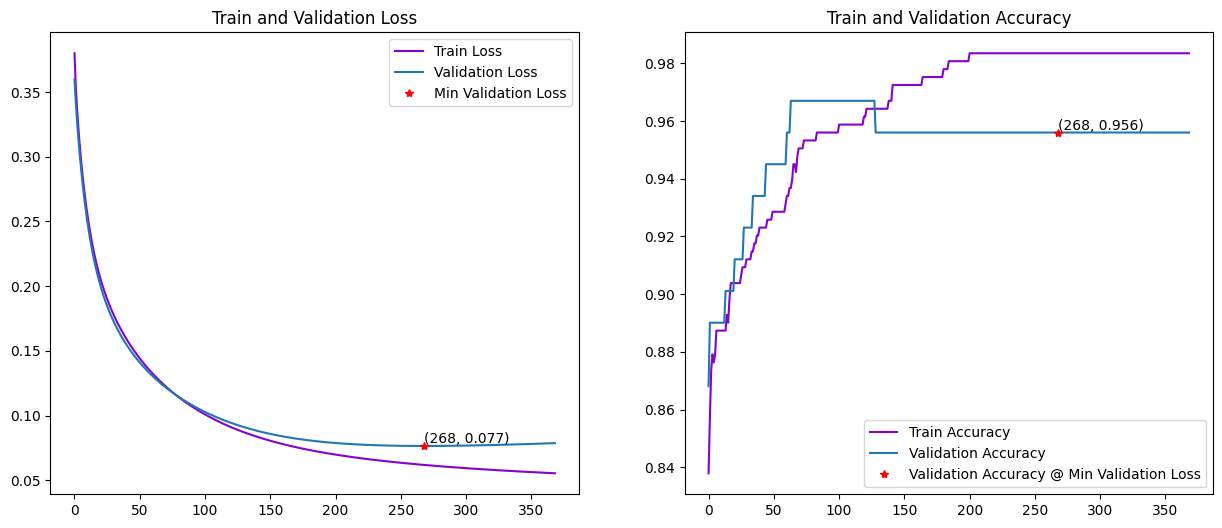

In [19]:
model_history(history)

In [20]:
model.set_weights(CURRENT_MODEL.get_weights())

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, batchSize=32, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
res_df

Train Accuracy Mean: 0.9813186645507812, Train Accuracy STD: 0.0035819597012781536
Validation Accuracy Mean: 0.9736263751983643, Validation Accuracy STD: 0.01666565932324605
Validation Loss Mean: 0.07026891484856605, Validation Loss STD: 0.037668299916775845


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,0,0.980769,0.065816,0.956044,0.078884,1.000000
1,1,0.983516,0.054996,0.978022,0.060968,0.969697
2,2,0.983516,0.049316,0.956044,0.129823,0.909091
3,3,0.975275,0.059688,0.989011,0.051684,1.000000
4,4,0.983516,0.049276,0.989011,0.029985,1.000000


#### Optimizers

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.adam.Adam'>


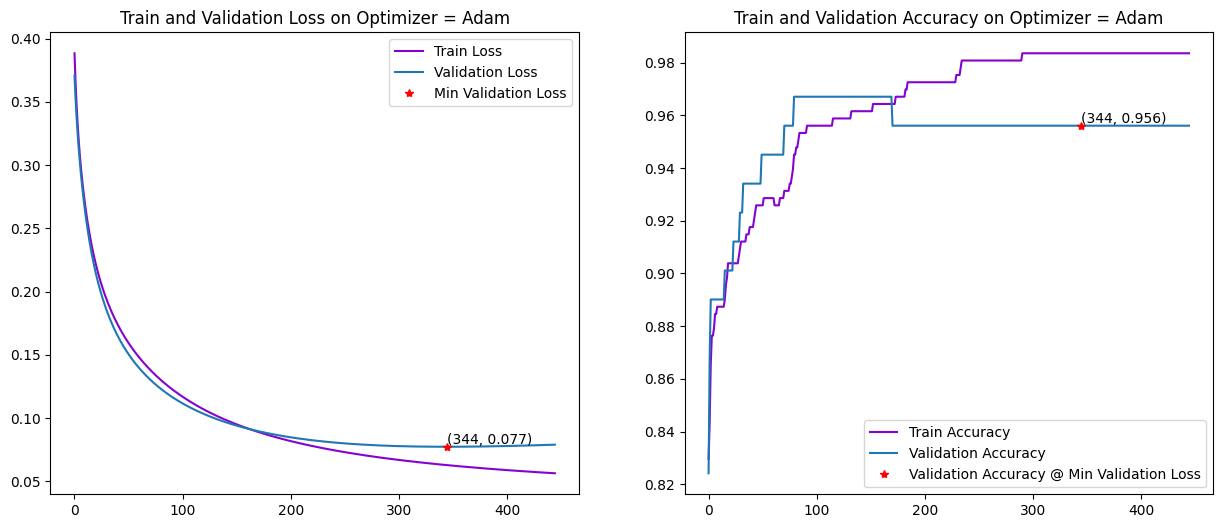

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.rmsprop.RMSprop'>


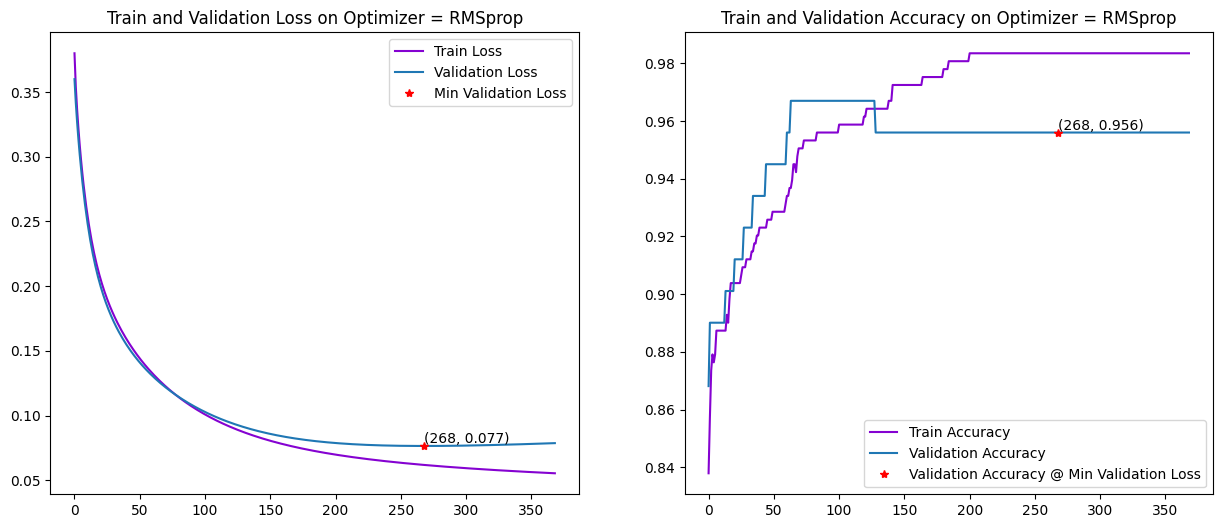

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.sgd.SGD'>


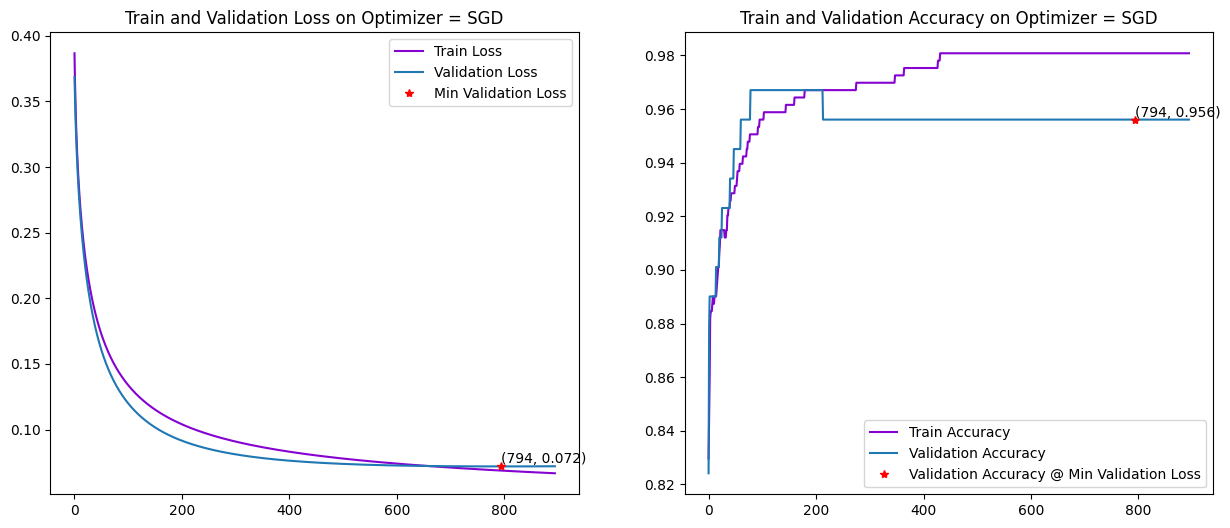

------------------------------------------------------------------------------------------------------------------
Optimizer = <class 'keras.src.optimizers.adagrad.Adagrad'>


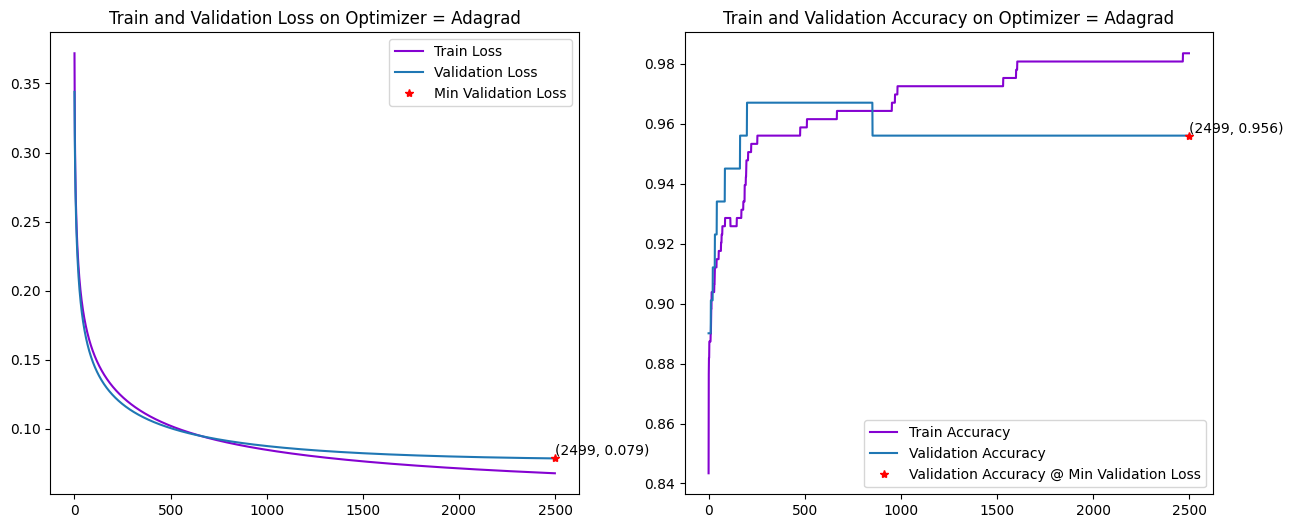

In [21]:
df_optimizer = pd.DataFrame(columns=['Optimizer', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

for optimizer in [optimizers.Adam, optimizers.RMSprop, optimizers.SGD, optimizers.Adagrad]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Optimizer = {optimizer}')    
        
    model.set_weights(CURRENT_MODEL.get_weights())   

    learning_rate = 0.001
    if(optimizer == optimizers.SGD or optimizer==optimizers.Adagrad):
        learning_rate = 0.01

    history, model = model_fit(model, optimizer=optimizer, learning_rate = learning_rate, epochNum=2500, en_early_stopping=True, verbose=0)        
    proc_data = proc_history(history)
    
    new_row = {'Optimizer': optimizer.__name__, **proc_data}
    df_optimizer.loc[len(df_optimizer)] = new_row
    model_history(history, f'Optimizer = {optimizer.__name__}')


In [22]:
df_optimizer

,Optimizer,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,Adam,0.983516,0.062761,0.956044,0.077267,0.972222
1,RMSprop,0.983516,0.061848,0.956044,0.076520,0.972222
2,SGD,0.980769,0.068721,0.956044,0.071891,0.972222
3,Adagrad,0.983516,0.067868,0.956044,0.078624,0.972222


Conclusion: We can see in the graphs that the optimizers achieve similar results, while SGD and Adagrad take a large amount of Epochs to converge.

In [23]:
model.set_weights(CURRENT_MODEL.get_weights())
ADAM_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=optimizers.Adam, learning_rate=0.001, epochNum=2500, batchSize=32, verbose=0)

model.set_weights(CURRENT_MODEL.get_weights())
RMS_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=optimizers.RMSprop, learning_rate=0.001, epochNum=2500, batchSize=32, verbose=0)

model.set_weights(CURRENT_MODEL.get_weights())
SGD_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=optimizers.SGD, learning_rate=0.01, epochNum=2500, batchSize=32, verbose=0)

In [24]:
print(f"Validation Loss Mean: {ADAM_res_df['Validation Loss'].mean()}, Validation Loss STD: {ADAM_res_df['Validation Loss'].std()}")
ADAM_res_df

Validation Loss Mean: 0.07074258252978324, Validation Loss STD: 0.03823078094734371


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,0,0.978022,0.066463,0.956044,0.079941,1.000000
1,1,0.983516,0.054778,0.978022,0.063347,0.969697
2,2,0.983516,0.051047,0.956044,0.130408,0.909091
3,3,0.975275,0.055278,0.989011,0.051363,1.000000
4,4,0.980769,0.046304,0.989011,0.028653,1.000000


In [25]:
print(f"Validation Loss Mean: {RMS_res_df['Validation Loss'].mean()}, Validation Loss STD: {RMS_res_df['Validation Loss'].std()}")
RMS_res_df

Validation Loss Mean: 0.07026891484856605, Validation Loss STD: 0.037668299916775845


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,0,0.980769,0.065816,0.956044,0.078884,1.000000
1,1,0.983516,0.054996,0.978022,0.060968,0.969697
2,2,0.983516,0.049316,0.956044,0.129823,0.909091
3,3,0.975275,0.059688,0.989011,0.051684,1.000000
4,4,0.983516,0.049276,0.989011,0.029985,1.000000


In [26]:
print(f"Validation Loss Mean: {SGD_res_df['Validation Loss'].mean()}, Validation Loss STD: {SGD_res_df['Validation Loss'].std()}")
SGD_res_df

Validation Loss Mean: 0.07167509570717812, Validation Loss STD: 0.03205832387176785


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,0,0.978022,0.066654,0.978022,0.065072,1.000000
1,1,0.983516,0.055482,0.978022,0.063810,0.969697
2,2,0.989011,0.056224,0.956044,0.127681,0.909091
3,3,0.975275,0.061839,0.978022,0.052644,1.000000
4,4,0.980769,0.061105,0.978022,0.049167,0.969697


Conclusion: We will take the best Optimizer as SGD, as it yields the lowest STD value in the Validation Loss.

In [27]:
BEST_OPTIMIZER = optimizers.SGD

#### Learning-Rate

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.1


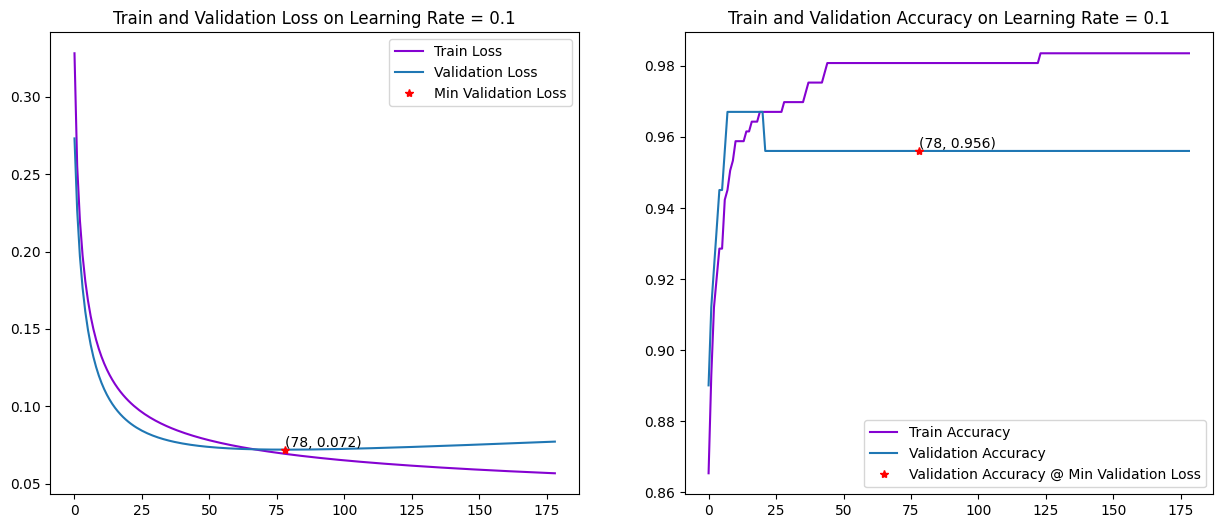

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.01


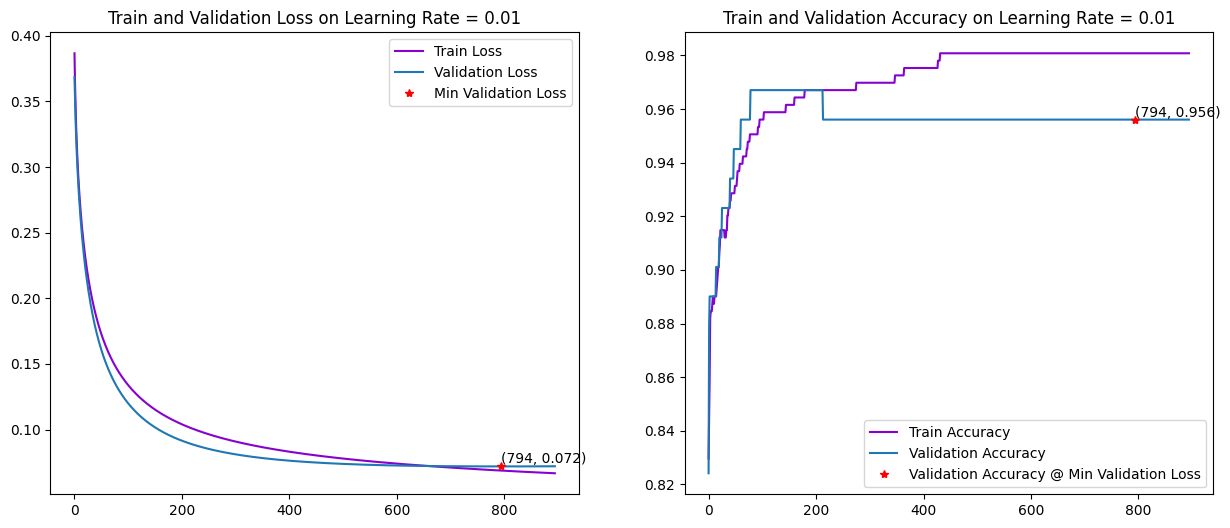

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.001


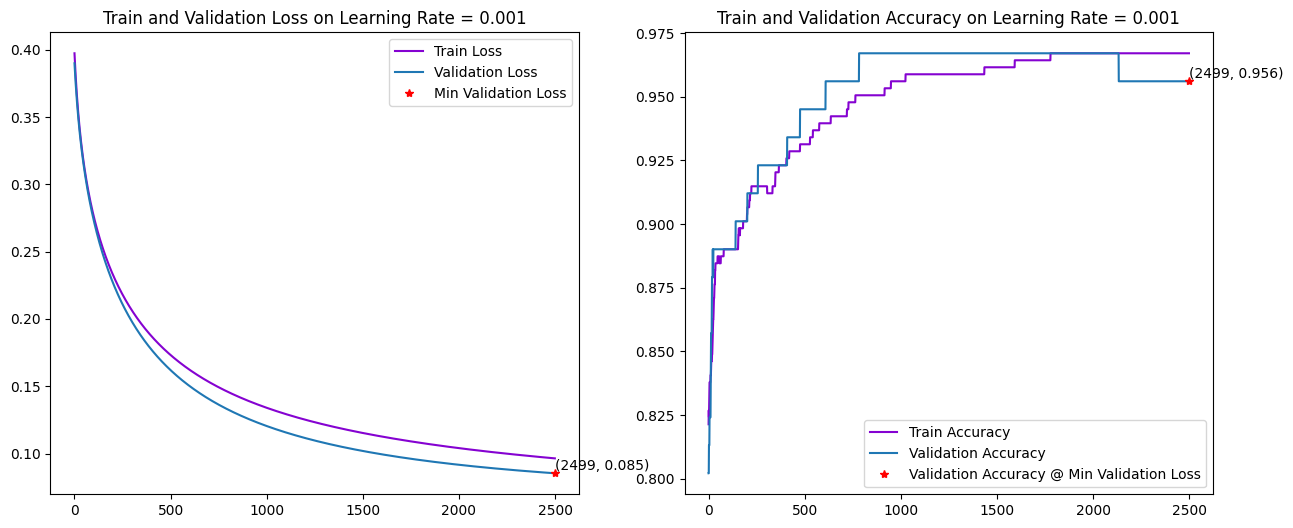

------------------------------------------------------------------------------------------------------------------
Learning Rate = 0.0001


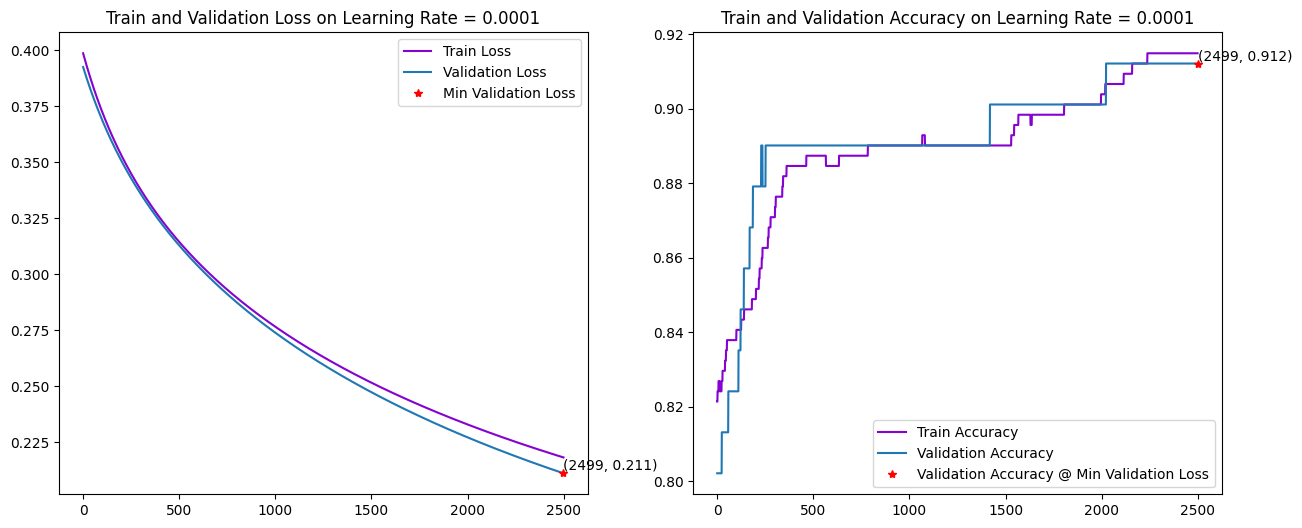

In [28]:
df_res = pd.DataFrame(columns=['Learning Rate', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

for learning_rate in [0.1, 0.01, 0.001, 0.0001]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Learning Rate = {learning_rate}')    
        
    model.set_weights(CURRENT_MODEL.get_weights())   

    history, model = model_fit(model, optimizer=BEST_OPTIMIZER, learning_rate=learning_rate, epochNum=2500, en_early_stopping=True, verbose=0)
    proc_data = proc_history(history)
    
    new_row = {'Learning Rate': learning_rate, **proc_data}
    df_res.loc[len(df_res)] = new_row
    model_history(history, f'Learning Rate = {learning_rate}')


Conlusion: From the graphs above, we can infer that a learning rate of 0.1 and 0.01 yields the same results, however with a learning rate of 0.1 it yields the result 10 times faster, which means the model can handle a large learning rate at the begining of the training. <br>
In the next steps, we will include a learning rate scheduler, which will decrease the learning rate once it reaches a plateau.

In [29]:
BEST_LEARNING_RATE = 0.001

#### Network Architecture

In [30]:
nn_arch_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

##### NN 30x1

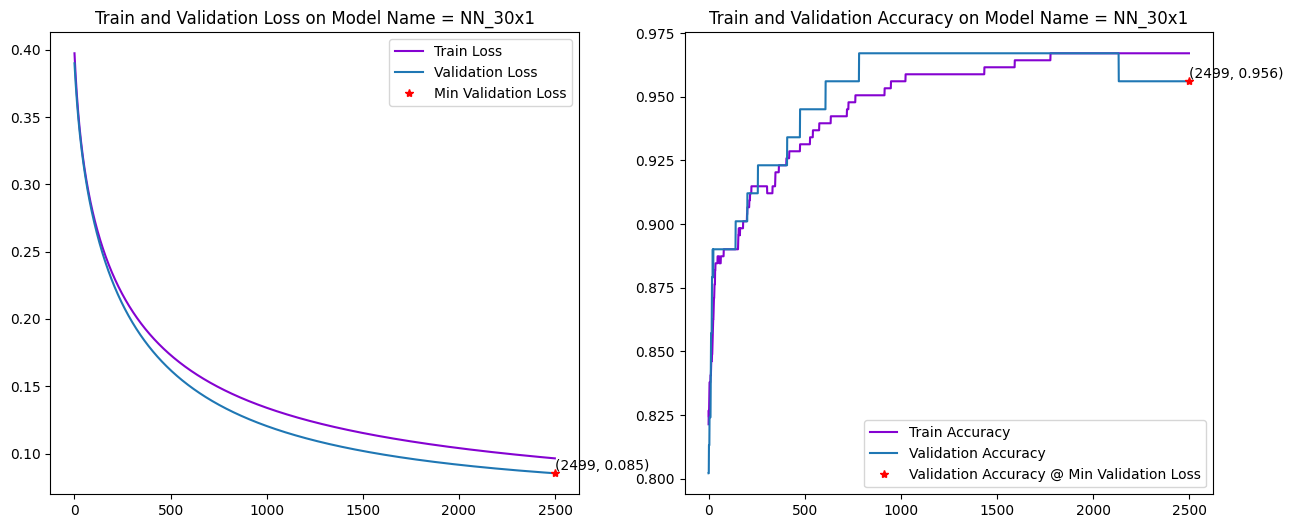

{'Train Accuracy': 0.9670329689979553,
 'Train Loss': 0.09640217572450638,
 'Validation Accuracy': 0.9560439586639404,
 'Validation Loss': 0.08532591909170151,
 'Validation Recall': 0.9722222089767456}

In [31]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### First Hidden Layer

##### NN 30x1x1

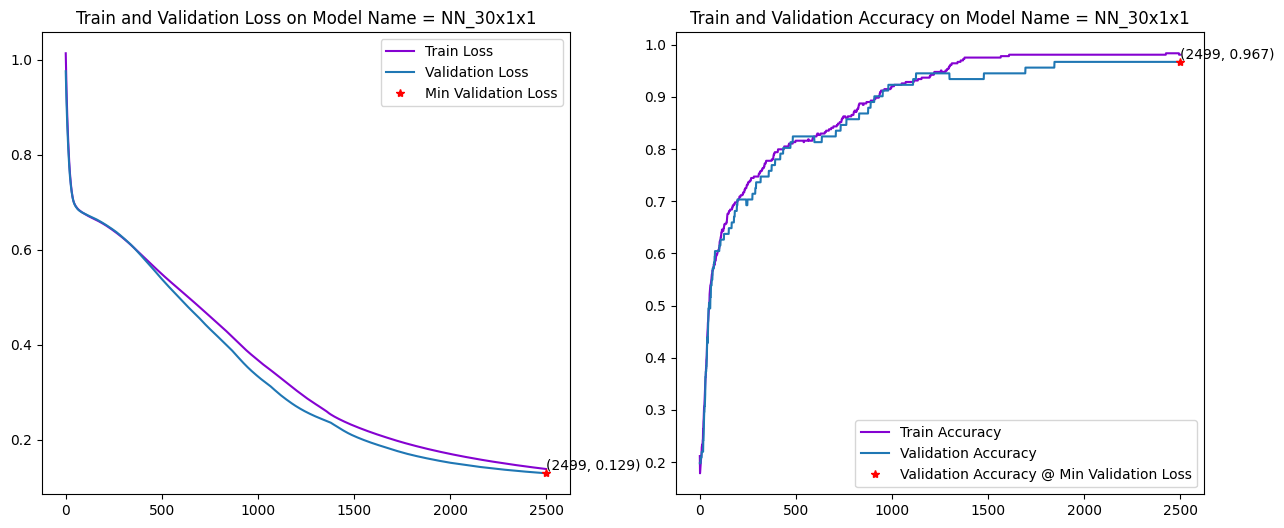

{'Train Accuracy': 0.9807692170143127,
 'Train Loss': 0.13845305144786835,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.1294722706079483,
 'Validation Recall': 0.9722222089767456}

In [32]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x1x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x5x1

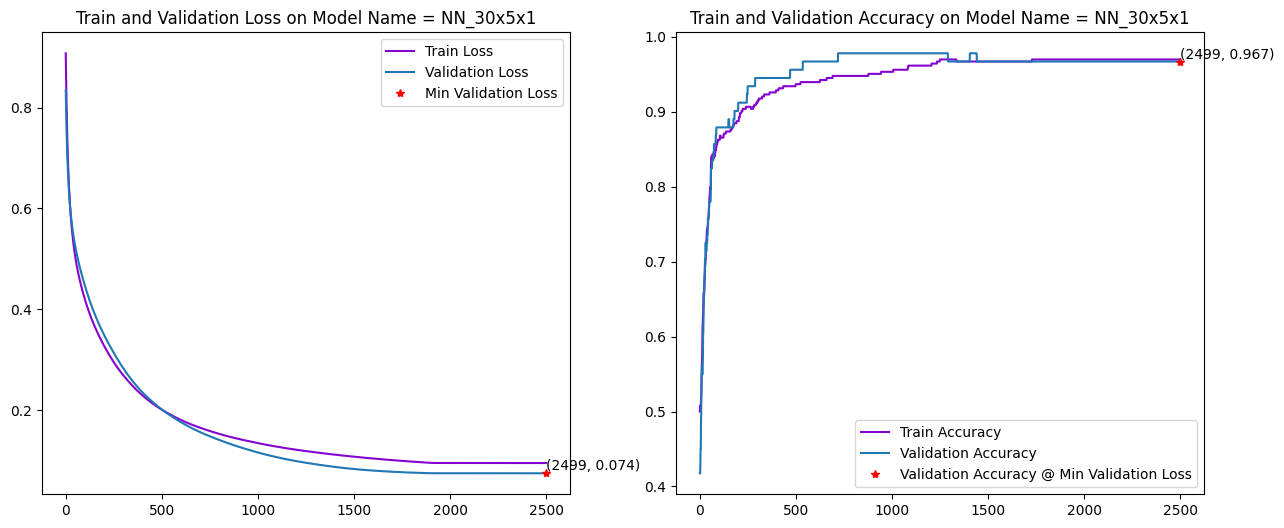

{'Train Accuracy': 0.9697802066802979,
 'Train Loss': 0.09460758417844772,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.07429806888103485,
 'Validation Recall': 0.9722222089767456}

In [33]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x10x1

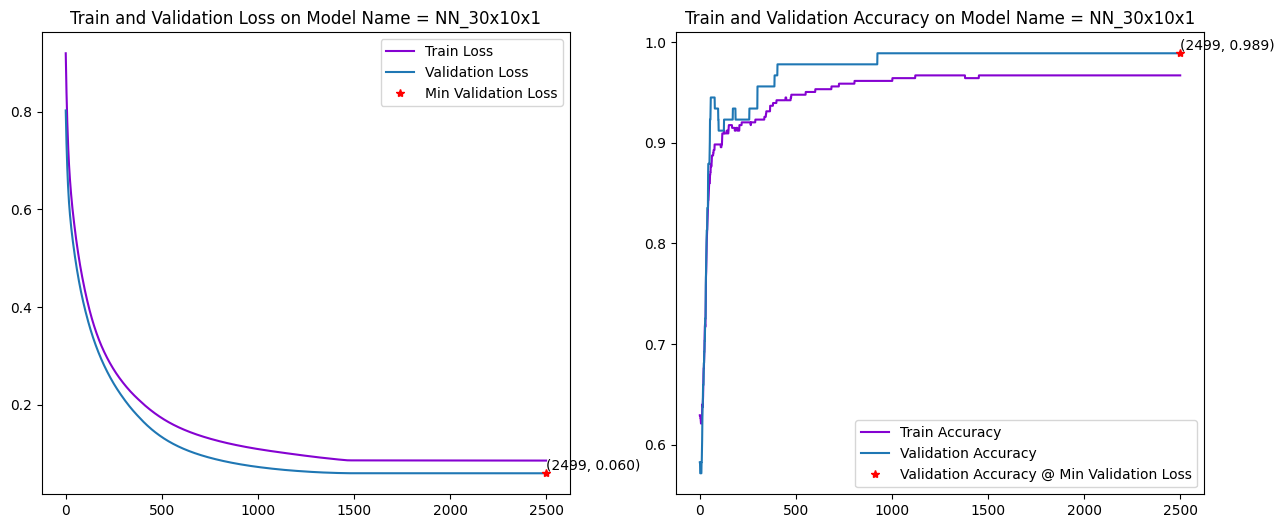

{'Train Accuracy': 0.9670329689979553,
 'Train Loss': 0.08609465509653091,
 'Validation Accuracy': 0.9890109896659851,
 'Validation Loss': 0.06010943278670311,
 'Validation Recall': 0.9722222089767456}

In [34]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x20x1

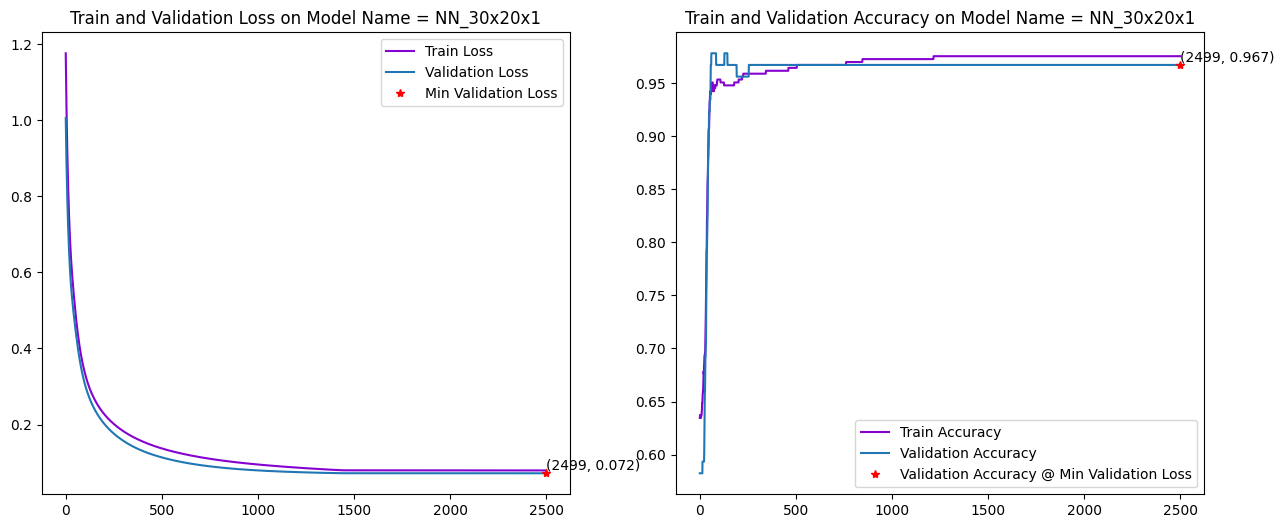

{'Train Accuracy': 0.9752747416496277,
 'Train Loss': 0.07940088957548141,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.07189258188009262,
 'Validation Recall': 0.9722222089767456}

In [35]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x20x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x1

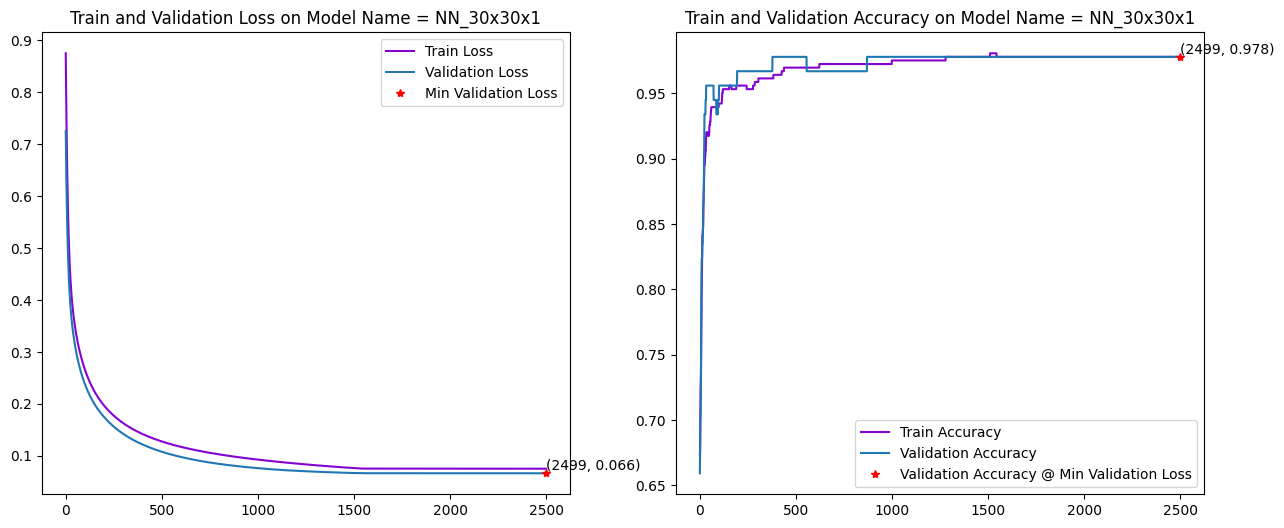

{'Train Accuracy': 0.9780219793319702,
 'Train Loss': 0.07511276751756668,
 'Validation Accuracy': 0.9780219793319702,
 'Validation Loss': 0.06630340218544006,
 'Validation Recall': 0.9722222089767456}

In [36]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

Concluion: We see that NN_30x30x1 is yields the best results for 1st hidden layer. <br>
We will check what is the best activation function for this layer.

In [37]:
nn_arch_df

,Model Name,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,NN_30x1,0.967033,0.096402,0.956044,0.085326,0.972222
1,NN_30x1x1,0.980769,0.138453,0.967033,0.129472,0.972222
2,NN_30x5x1,0.969780,0.094608,0.967033,0.074298,0.972222
3,NN_30x10x1,0.967033,0.086095,0.989011,0.060109,0.972222
4,NN_30x20x1,0.975275,0.079401,0.967033,0.071893,0.972222
5,NN_30x30x1,0.978022,0.075113,0.978022,0.066303,0.972222


In [38]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, epochNum=2500, batchSize=32, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
res_df

Train Accuracy Mean: 0.9835164785385132, Train Accuracy STD: 0.0027472674846972466
Validation Accuracy Mean: 0.9736263751983643, Validation Accuracy STD: 0.01252939952900425
Validation Loss Mean: 0.08055021464824677, Validation Loss STD: 0.03779731529551908


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,0,0.980769,0.066628,0.978022,0.065981,1.000000
1,1,0.986264,0.066777,0.978022,0.069899,0.939394
2,2,0.986264,0.062149,0.956044,0.147170,0.909091
3,3,0.983516,0.067348,0.967033,0.053006,0.969697
4,4,0.980769,0.062145,0.989011,0.066695,1.000000


In [39]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, epochNum=2500, batchSize=32, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
res_df

Train Accuracy Mean: 0.9747252702713013, Train Accuracy STD: 0.0022985324487299883
Validation Accuracy Mean: 0.9692307710647583, Validation Accuracy STD: 0.009194065677640131
Validation Loss Mean: 0.08361297994852065, Validation Loss STD: 0.025692182187583325


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,0,0.972527,0.070209,0.967033,0.069941,1.000000
1,1,0.975275,0.068461,0.978022,0.074661,0.969697
2,2,0.978022,0.067339,0.956044,0.127998,0.909091
3,3,0.972527,0.077204,0.978022,0.063608,1.000000
4,4,0.975275,0.065022,0.967033,0.081857,1.000000


#### First Hidden Layer Activation Functions

##### NN 30x10x1 - leaky_relu

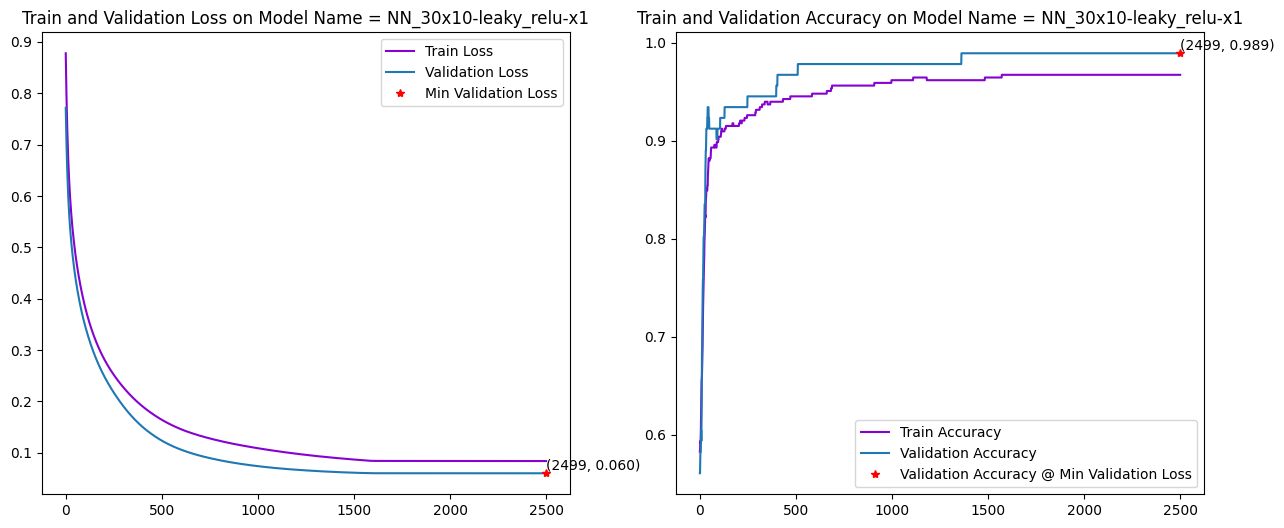

{'Train Accuracy': 0.9670329689979553,
 'Train Loss': 0.08381832391023636,
 'Validation Accuracy': 0.9890109896659851,
 'Validation Loss': 0.06001463532447815,
 'Validation Recall': 0.9722222089767456}

In [40]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10-leaky_relu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='leaky_relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x10x1 - silu

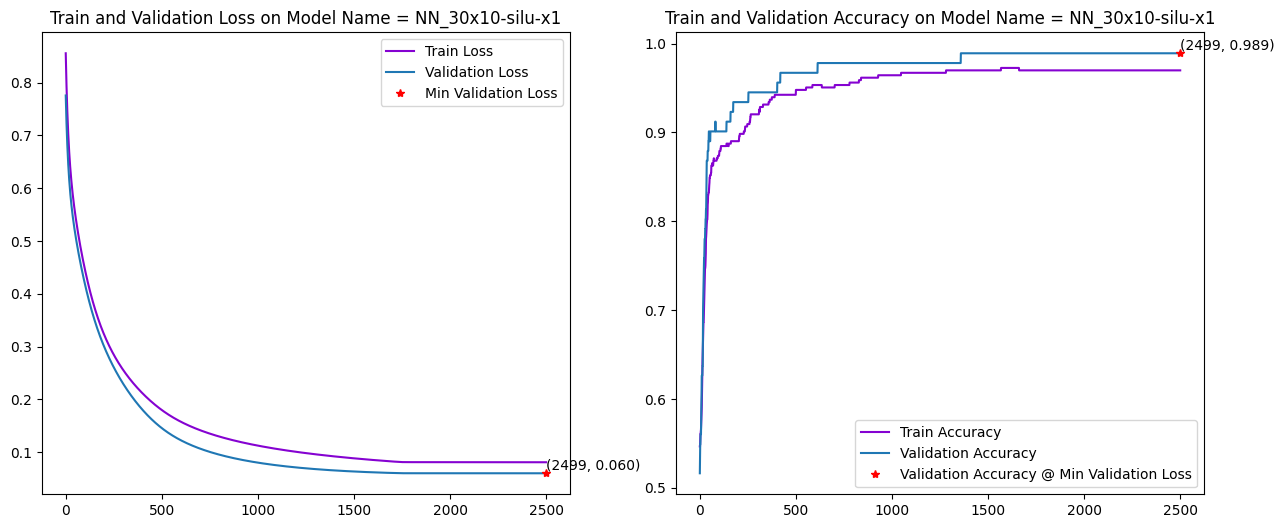

{'Train Accuracy': 0.9697802066802979,
 'Train Loss': 0.08083721250295639,
 'Validation Accuracy': 0.9890109896659851,
 'Validation Loss': 0.059943169355392456,
 'Validation Recall': 0.9722222089767456}

In [41]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10-silu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='silu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x10x1 - elu

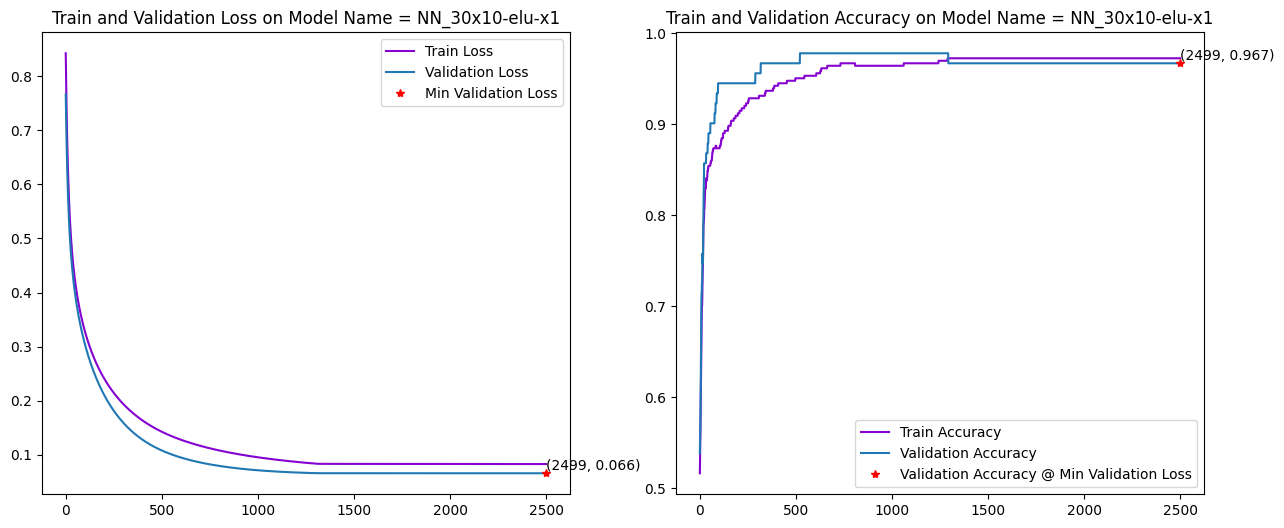

{'Train Accuracy': 0.9725274443626404,
 'Train Loss': 0.08297763764858246,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.06591738015413284,
 'Validation Recall': 0.9722222089767456}

In [42]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10-elu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x10x1 - tanh

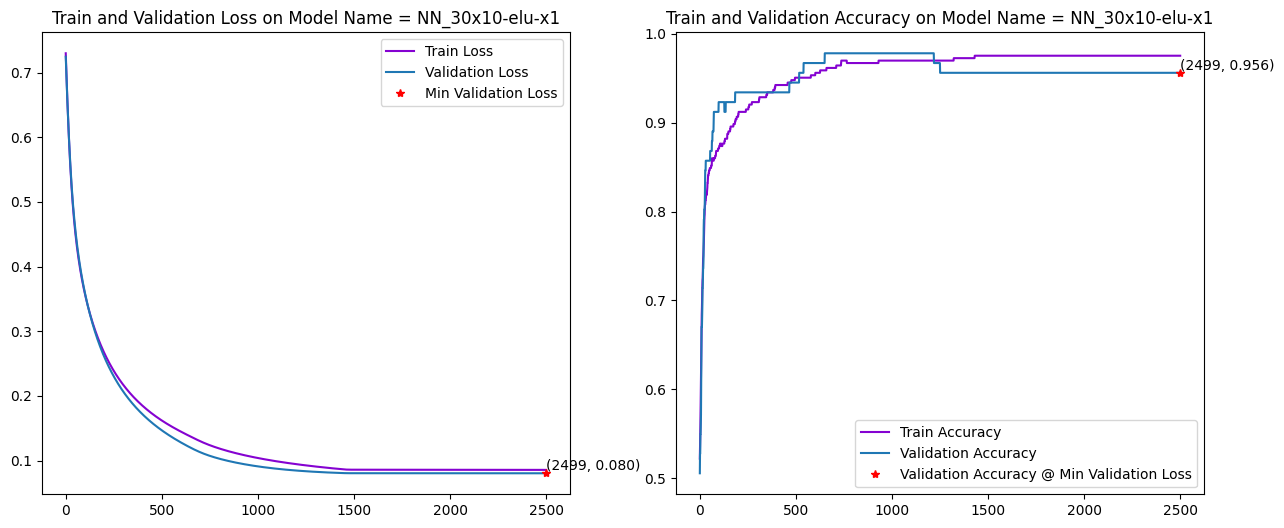

{'Train Accuracy': 0.9752747416496277,
 'Train Loss': 0.08550179749727249,
 'Validation Accuracy': 0.9560439586639404,
 'Validation Loss': 0.08024975657463074,
 'Validation Recall': 0.9722222089767456}

In [43]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10-elu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

Concluion: We see that relu yields the best results for 1st hidden layer activation function. <br>

#### Second Hidden Layer

##### NN 30x10x1x1

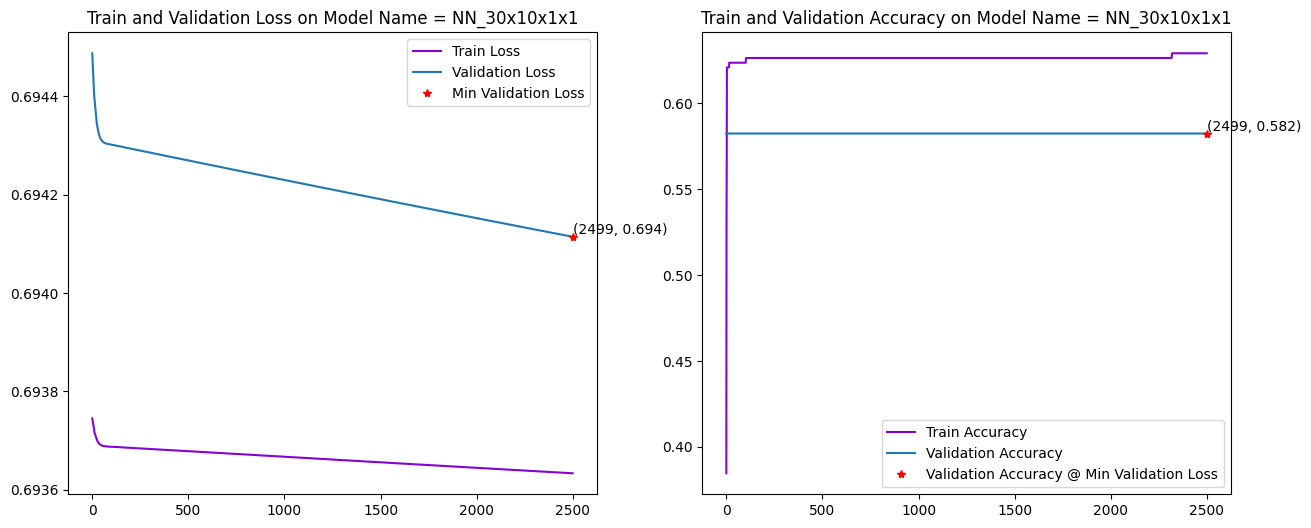

{'Train Accuracy': 0.6291208863258362,
 'Train Loss': 0.6936336755752563,
 'Validation Accuracy': 0.5824176073074341,
 'Validation Loss': 0.6941142082214355,
 'Validation Recall': 0.0}

In [44]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x1x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x10x5x1

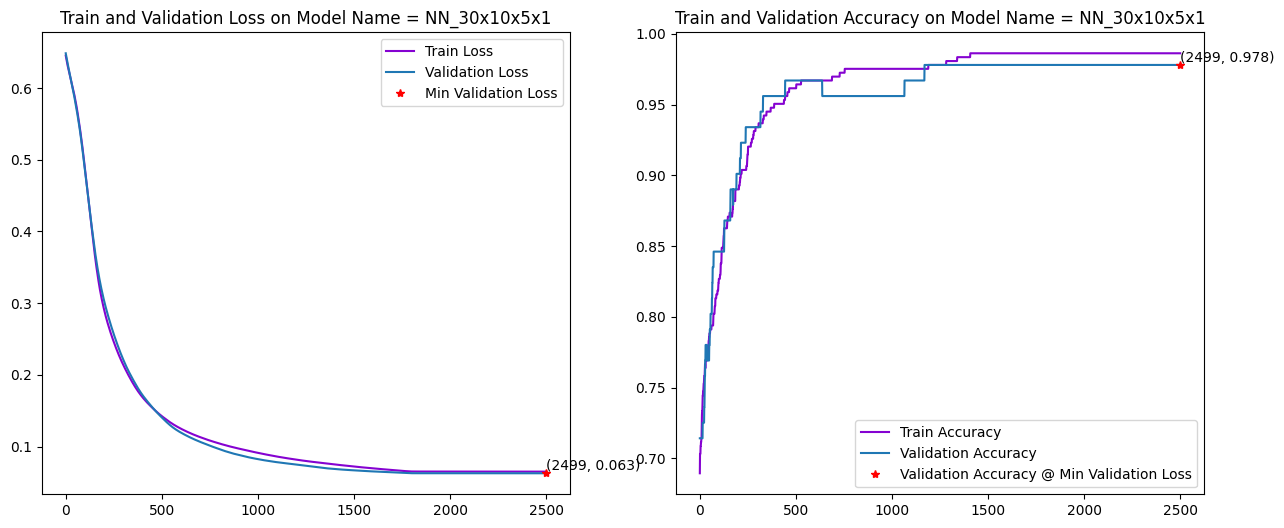

{'Train Accuracy': 0.9862637519836426,
 'Train Loss': 0.06507276743650436,
 'Validation Accuracy': 0.9780219793319702,
 'Validation Loss': 0.06277729570865631,
 'Validation Recall': 0.9722222089767456}

In [45]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x10x10x1

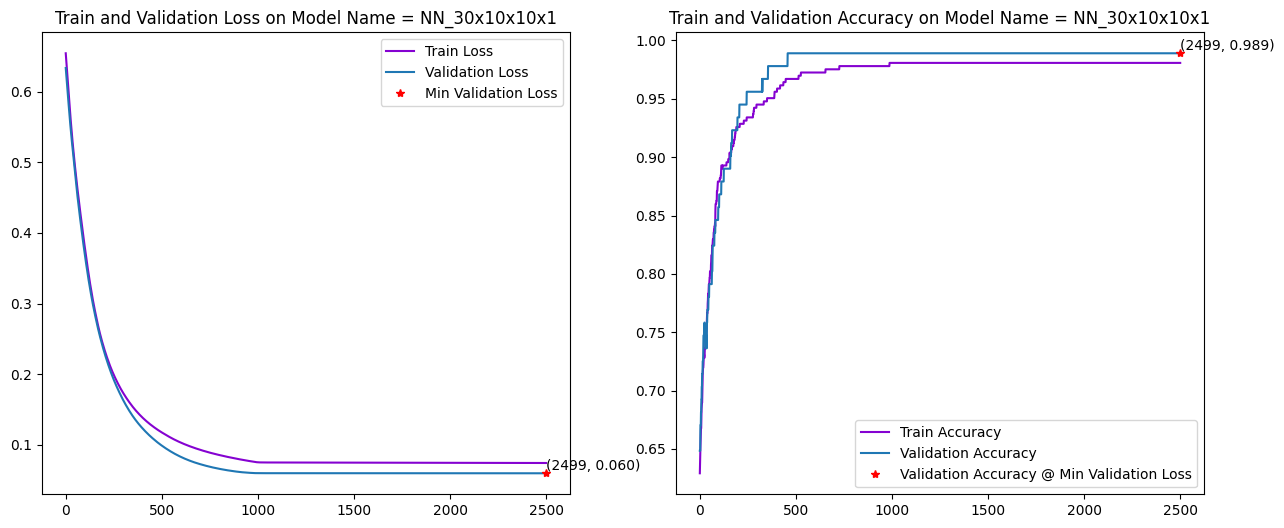

{'Train Accuracy': 0.9807692170143127,
 'Train Loss': 0.07432836294174194,
 'Validation Accuracy': 0.9890109896659851,
 'Validation Loss': 0.05977234989404678,
 'Validation Recall': 0.9722222089767456}

In [46]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x10x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x10x20x1

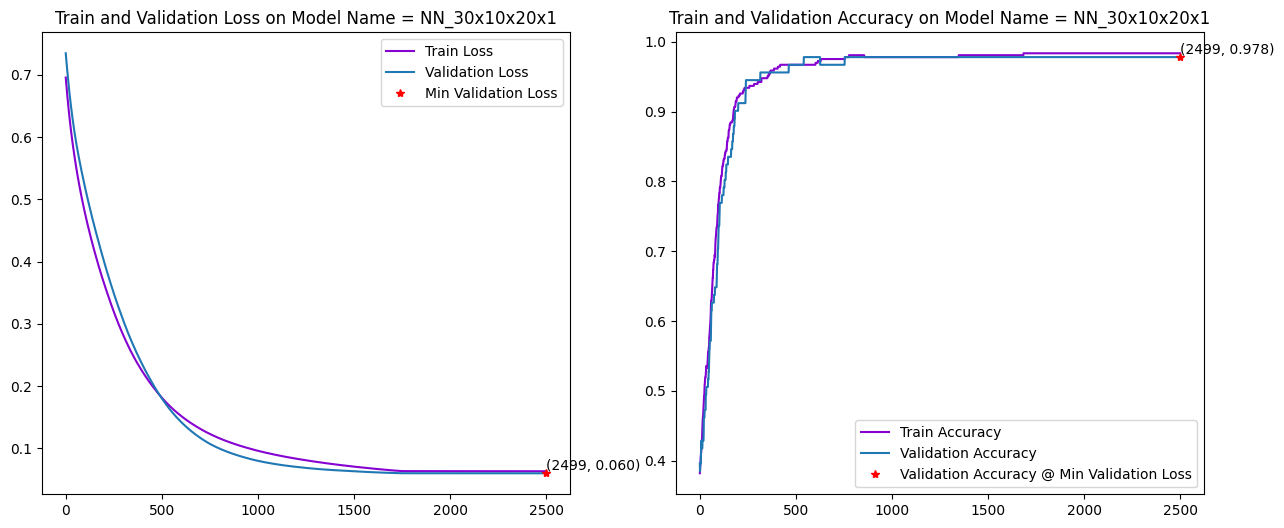

{'Train Accuracy': 0.9835164546966553,
 'Train Loss': 0.06343059986829758,
 'Validation Accuracy': 0.9780219793319702,
 'Validation Loss': 0.0601724274456501,
 'Validation Recall': 0.9722222089767456}

In [47]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x20x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x10x30x1

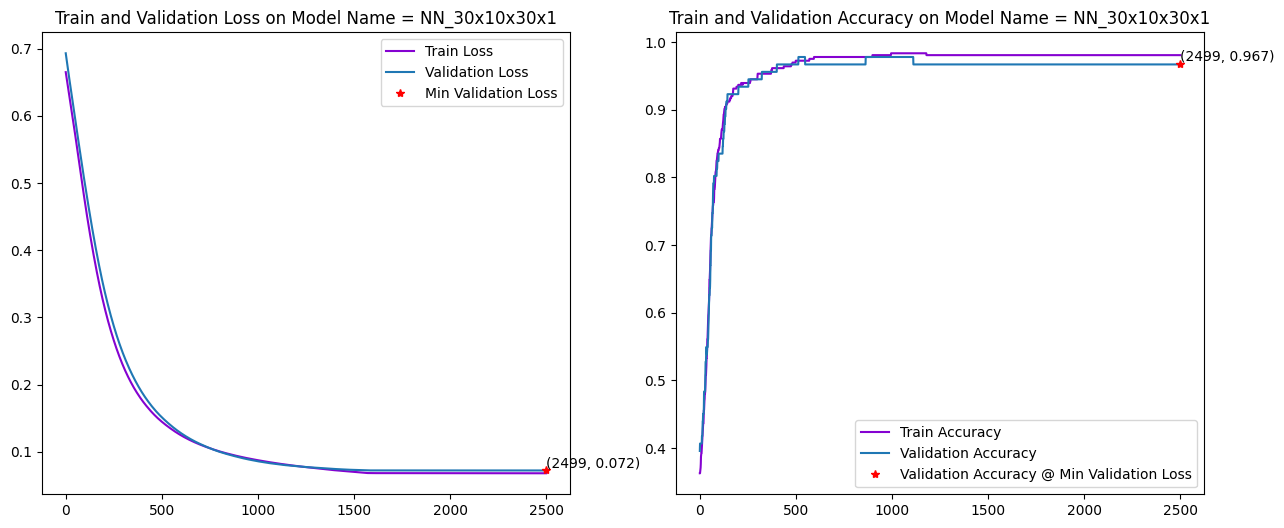

{'Train Accuracy': 0.9807692170143127,
 'Train Loss': 0.06822548806667328,
 'Validation Accuracy': 0.9670329689979553,
 'Validation Loss': 0.07242180407047272,
 'Validation Recall': 0.9722222089767456}

In [48]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x30x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

Concluion: We see that NN_30x30x5x1 is yields the best results for 2st hidden layer. <br>
We will check what is the best activation function for this layer.

In [49]:
nn_arch_df

,Model Name,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,NN_30x1,0.967033,0.096402,0.956044,0.085326,0.972222
1,NN_30x1x1,0.980769,0.138453,0.967033,0.129472,0.972222
2,NN_30x5x1,0.969780,0.094608,0.967033,0.074298,0.972222
3,NN_30x10x1,0.967033,0.086095,0.989011,0.060109,0.972222
4,NN_30x20x1,0.975275,0.079401,0.967033,0.071893,0.972222
5,NN_30x30x1,0.978022,0.075113,0.978022,0.066303,0.972222
6,NN_30x10-leaky_relu-x1,0.967033,0.083818,0.989011,0.060015,0.972222
7,NN_30x10-silu-x1,0.969780,0.080837,0.989011,0.059943,0.972222
8,NN_30x10-elu-x1,0.972527,0.082978,0.967033,0.065917,0.972222
9,NN_30x10-elu-x1,0.975275,0.085502,0.956044,0.080250,0.972222


In [50]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x10x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, epochNum=2500, batchSize=32, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
res_df

Train Accuracy Mean: 0.9813186764717102, Train Accuracy STD: 0.004514197540311081
Validation Accuracy Mean: 0.9692307710647583, Validation Accuracy STD: 0.012037857689194673
Validation Loss Mean: 0.08343532532453538, Validation Loss STD: 0.023984868483570274


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,0,0.978022,0.063445,0.967033,0.070519,1.000000
1,1,0.980769,0.071411,0.967033,0.085402,0.939394
2,2,0.989011,0.057342,0.956044,0.124411,0.909091
3,3,0.978022,0.070642,0.989011,0.067855,1.000000
4,4,0.980769,0.058112,0.967033,0.068990,1.000000


In [51]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x10x20x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, epochNum=2500, batchSize=32, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
res_df

Train Accuracy Mean: 0.9862637281417846, Train Accuracy STD: 0.0027472674846972466
Validation Accuracy Mean: 0.9714285731315613, Validation Accuracy STD: 0.01252939952900425
Validation Loss Mean: 0.08056501522660256, Validation Loss STD: 0.044258776278461004


,k,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Validation Recall
0,0,0.983516,0.056147,0.989011,0.040842,1.000000
1,1,0.983516,0.062642,0.967033,0.077398,0.939394
2,2,0.989011,0.058209,0.956044,0.156116,0.909091
3,3,0.986264,0.061723,0.978022,0.062492,1.000000
4,4,0.989011,0.056186,0.967033,0.065977,0.969697


#### Second Hidden Layer Activation Functions

##### NN 30x30x5x1 - leaky_relu

In [ ]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5-leaky_relu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='leaky_relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x5x1 - silu

In [ ]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5-silu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='silu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x5x1 - elu

In [ ]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5-elu-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

##### NN 30x30x5x1 - tanh

In [ ]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5-tanh-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_arch_df.loc[len(nn_arch_df)] = new_row

model_history(history)
proc_data

Concluion: We see that relu yields the best results for 2st hidden layer activation function. <br>

In [ ]:
nn_arch_df

In [ ]:
nn_arch_df.sort_values(by='Validation Loss')

Conclusion: We can see that the Network Architecture of 30x30x5x1 yields the best results, while a leaky-relu or relu activation function in the second hidden layer yields the same results, thus we will remain with the default activation function. <br>
We will check this network with KFolds.

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  
        
model = models.Sequential(name=f'NN_30x30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, epochNum=2500, batchSize=32, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
res_df

<b><u>Conclusion:</u></b> We can see that the 30x30x5x1 is the Network Architecture that yields the best and stable results. <br>
With that said, we will also still take the SLP, which is the basic Network Architecture (No hidden layers) into consideration.

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

#### Batch-Size

In [ ]:
df_batch_size = pd.DataFrame(columns=['Batch Size', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

model = models.clone_model(BEST_MODEL)

for batch_size in [1, 2, 4, 8, 16, 32, 64, 128]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Batch Size = {batch_size}')    
        
    model.set_weights(BEST_MODEL.get_weights())   

    history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=batch_size, en_early_stopping=True, en_reduce_lr=True, verbose=0)
    proc_data = proc_history(history)
    
    new_row = {'Batch Size': batch_size, **proc_data}
    df_batch_size.loc[len(df_batch_size)] = new_row
    model_history(history, f'Batch Size = {batch_size}')


In [ ]:
for batch_size in [1, 2, 4, 8, 16, 32, 64, 128]:
    model.set_weights(BEST_MODEL.get_weights())
    batch_size_res_df = model_kfold(X_train_val, y_train_val, model, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, epochNum=2500, batchSize=batch_size, en_reduce_lr=True, en_early_stopping=True, verbose=0)
    print('----------------------------------------------------------------------------------------------------')
    print(f'Batch Size = {batch_size}')
    print(f"Validation Loss Mean: {batch_size_res_df['Validation Loss'].mean()}, Validation Loss STD: {batch_size_res_df['Validation Loss'].std()}")    
    print(f"Validation Recall Mean: {batch_size_res_df['Validation Recall'].mean()}, Validation Recall STD: {batch_size_res_df['Validation Recall'].std()}")    
    print(batch_size_res_df)    


In [ ]:
df_batch_size

Conclusion: As we can see from the results, BATCH_SIZE = 8 yielded the best results in the Validation Loss (mean), <br> 
As well as over the recall metric in the 5 folds. Thus, we will choose BATCH_SIZE = 8 as the best BATCH_SIZE.

In [ ]:
BEST_BATCH_SIZE = 8

## Handling Overfitting

### Dropout

In [ ]:
nn_drop_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### Input Layer Dropout

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30-D2-x30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### First Layer Dropout

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-D3-x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Second Layer Dropout

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D3-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### First & Second Layer Dropout

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-D3-x5-D3-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### KFold Assessment

In [ ]:
nn_drop_df

##### Input Layer Dropout Assessment

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30-D2-x30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

##### First Layer Dropout Assessment

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-D3-x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

##### Second Layer Dropout Assessment

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D3-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

##### First & Second Layer Dropout Assessment

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-D3-x5-D3-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

#### Tune Dropout Rate = [0.1, 0.2, 0.3, 0.4, 0.5]

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

for rate in [0.1, 0.2, 0.3, 0.4, 0.5]:

    print('-----------------------------------------------------------------------------')
    print(f'Dropout Rate = {rate}')

    model = models.Sequential(name=f'NN_30x30x5-D{int(rate*10)}-x1')

    model.add(layers.Input((30,)))
    model.add(layers.Dense(30, activation='relu'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dropout(rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
    print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
    print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
    print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
    print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
    print(res_df)

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_drop_df.loc[len(nn_drop_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

Conclusion: We chose the best Dropout Addition to the Network as a Dropout to the Second Layer only with a rate of 0.1. <br>
Thus, we will update our BEST_MODEL.

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5-D1-x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

### L2

In [ ]:
nn_l2_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### First Layer L2

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30_L2_0001x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l2_df.loc[len(nn_l2_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Second Layer L2

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5_L2_0001x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l2_df.loc[len(nn_l2_df)] = new_row

model_history(history)
proc_data

#### First & Second Layer L2

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30_L2_0001x5_L2_0001x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l2_df.loc[len(nn_l2_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

In [ ]:
nn_l2_df

Conclusion: As we can see, adding the Regularization L2 didn't improve our model performance. <br>
Now we will check how L1 Regularization affects our model.

### L1

In [ ]:
nn_l1_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### First Layer L1

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30_L1_0001x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L1(0.0001)))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l1_df.loc[len(nn_l1_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Second Layer L1

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5_L1_0001x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L1(0.0001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l1_df.loc[len(nn_l1_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### First & Second Layer L1

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30_L2_0001x5_L1_0001x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu', kernel_regularizer=regularizers.L1(0.0001)))
model.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L1(0.0001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_l1_df.loc[len(nn_l1_df)] = new_row

model_history(history)
proc_data

In [ ]:
nn_l1_df

Conclusion: As we can see, adding the Regularization L1 also didn't improve our model performance. <br>
Thus, we will not use L2 nor L1 Regularizations.

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5-D1-x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

### Bottleneck

In [ ]:
nn_bottleneck_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### Bottleneck between Input and First Layers

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x1x30x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_bottleneck_df.loc[len(nn_bottleneck_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Bottleneck between First and Second Layers

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x3x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(3, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_bottleneck_df.loc[len(nn_bottleneck_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x1x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_bottleneck_df.loc[len(nn_bottleneck_df)] = new_row

model_history(history, f'Model Name = {model.name}')
proc_data

#### Bottleneck as First Layer

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x1x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_bottleneck_df.loc[len(nn_bottleneck_df)] = new_row

model_history(history)
proc_data

In [ ]:
nn_bottleneck_df

#### KFold Assessment

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x1x5x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

Conclusion: We will not continue with bottleneck when we check other parameters, <br>
However, we will try to see the results of this model on the X_test dataset lateron, because we see that this model could have potential due to its stable graph.

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5-D1-x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

### Batch Normalization

In [ ]:
nn_batchnorm_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

#### First Layer Batch Normalization

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30-BN-x5-D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_batchnorm_df.loc[len(nn_batchnorm_df)] = new_row

model_history(history, f'Batch Normalization = First Layer')
print(proc_data)

#### Second Layer Batch Normalization

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-BN--D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0)
proc_data = proc_history(history)

new_row = {'Model Name': model.name, **proc_data}
nn_batchnorm_df.loc[len(nn_batchnorm_df)] = new_row

model_history(history, f'Batch Normalization = Second Layer')
proc_data

In [ ]:
nn_batchnorm_df

#### First Layer KFold

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}") 
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

#### Second Layer KFold

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

model.add(layers.Input((30,)))
model.add(layers.Dense(30))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

res_df = model_kfold(X_train_val, y_train_val, model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_reduce_lr=True, en_early_stopping=True, verbose=0)
print(f"Train Accuracy Mean: {res_df['Train Accuracy'].mean()}, Train Accuracy STD: {res_df['Train Accuracy'].std()}")
print(f"Validation Accuracy Mean: {res_df['Validation Accuracy'].mean()}, Validation Accuracy STD: {res_df['Validation Accuracy'].std()}")    
print(f"Validation Loss Mean: {res_df['Validation Loss'].mean()}, Validation Loss STD: {res_df['Validation Loss'].std()}")    
print(f"Validation Recall Mean: {res_df['Validation Recall'].mean()}, Validation Recall STD: {res_df['Validation Recall'].std()}")    
res_df

Conclusion: This model didn't yield a higher validation score than our best model. <br>
For the rest of our parameters search, we will keep the previous best model.

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

BEST_MODEL = models.Sequential(name=f'NN_30x30x5-D1-x1')

BEST_MODEL.add(layers.Input((30,)))
BEST_MODEL.add(layers.Dense(30, activation='relu'))
BEST_MODEL.add(layers.Dense(5, activation='relu'))
BEST_MODEL.add(layers.Dropout(0.1))
BEST_MODEL.add(layers.Dense(1, activation='sigmoid'))

## Dimensionality Reduction

### PCA

In [ ]:
nn_pca_df = pd.DataFrame(columns=['PCA Components', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

In [ ]:
from sklearn import decomposition
pca_5 = decomposition.PCA(n_components=5)
pca_10 = decomposition.PCA(n_components=10)
pca_15 = decomposition.PCA(n_components=15)
pca_20 = decomposition.PCA(n_components=20)

#### PCA N_Components=5

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5x1')

X_train_pca_5 = pca_5.fit_transform(XData_train)
X_test_pca_5 = pca_5.transform(XData_test)
X_val_pca_5 = pca_5.transform(XData_val)

model.add(layers.Input((X_train_pca_5.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_pca_5 = RobustScaler()
X_train_pca_5 = scaler_pca_5.fit_transform(X_train_pca_5)
X_test_pca_5 = scaler_pca_5.transform(X_test_pca_5)
X_val_pca_5 = scaler_pca_5.transform(X_val_pca_5)

dataset = {'X_train': X_train_pca_5, 'y_train': y_train, 'X_val': X_val_pca_5, 'y_val': y_val}
history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'PCA Components': 5, **proc_data}
nn_pca_df.loc[len(nn_pca_df)] = new_row

model_history(history, f'PCA Components = 5')
proc_data

#### PCA N_Components=10

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5x1')

X_train_pca_10 = pca_10.fit_transform(XData_train)
X_test_pca_10 = pca_10.transform(XData_test)
X_val_pca_10 = pca_10.transform(XData_val)

model.add(layers.Input((X_train_pca_10.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_pca_10 = RobustScaler()
X_train_pca_10 = scaler_pca_10.fit_transform(X_train_pca_10)
X_test_pca_10 = scaler_pca_10.transform(X_test_pca_10)
X_val_pca_10 = scaler_pca_10.transform(X_val_pca_10)

dataset = {'X_train': X_train_pca_10, 'y_train': y_train, 'X_val': X_val_pca_10, 'y_val': y_val}
history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'PCA Components': 10, **proc_data}
nn_pca_df.loc[len(nn_pca_df)] = new_row

model_history(history, f'PCA Components = 10')
proc_data

#### PCA N_Components=15

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5x1')

X_train_pca_15 = pca_15.fit_transform(XData_train)
X_test_pca_15 = pca_15.transform(XData_test)
X_val_pca_15 = pca_15.transform(XData_val)

model.add(layers.Input((X_train_pca_15.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_pca_15 = RobustScaler()
X_train_pca_15 = scaler_pca_15.fit_transform(X_train_pca_15)
X_test_pca_15 = scaler_pca_15.transform(X_test_pca_15)
X_val_pca_15 = scaler_pca_15.transform(X_val_pca_15)

dataset = {'X_train': X_train_pca_15, 'y_train': y_train, 'X_val': X_val_pca_15, 'y_val': y_val}
history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'PCA Components': 15, **proc_data}
nn_pca_df.loc[len(nn_pca_df)] = new_row

model_history(history, f'PCA Components = 15')
proc_data

#### PCA N_Components=20

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5x1')

X_train_pca_20 = pca_20.fit_transform(XData_train)
X_test_pca_20 = pca_20.transform(XData_test)
X_val_pca_20 = pca_20.transform(XData_val)

model.add(layers.Input((X_train_pca_20.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_pca_20 = RobustScaler()
X_train_pca_20 = scaler_pca_20.fit_transform(X_train_pca_20)
X_test_pca_20 = scaler_pca_20.transform(X_test_pca_20)
X_val_pca_20 = scaler_pca_20.transform(X_val_pca_20)

dataset = {'X_train': X_train_pca_20, 'y_train': y_train, 'X_val': X_val_pca_20, 'y_val': y_val}
history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'PCA Components': 20, **proc_data}
nn_pca_df.loc[len(nn_pca_df)] = new_row

model_history(history, f'PCA Components = 20')
proc_data

In [ ]:
nn_pca_df

Conclusion: In our case, using PCA didn't help our model to learn better. <br>
We do see that even with fewer features, the model can achieve good enough results.

### Features Correlation

In [ ]:
nn_corr_df = pd.DataFrame(columns=['Threshold', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Validation Recall'])

As we saw in our EDA, there are some features that correlates to each other. Therefore, we can remove them in order to reduce the dimensionality of the problem and to make the model learn more easily. <br>
We will check how it affects the performance of our best model.

#### Correlation Matrix

In [ ]:
corr = XData_train.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 8},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of Breast Cancer Dataset Features', y=1.05, size=15)

We can see there are some correlated features in our dataset. <br>
We will evaluate how many features we remove for different thresholds.

Remove features that are above the defined threshold

In [ ]:
def get_corr_columns(X, threshold):

    # Compute the correlation matrix
    corr_matrix = X.corr()

    # Create a mask to identify upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of features with correlation greater than the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]    
                                                                
    # Drop the highly correlated features
    X_reduced = X.drop(columns=to_drop)    

    return {'number of features to drop': len(to_drop), 'to_drop': to_drop, 'reduced': list(X_reduced.columns)}

df_corr_comp = pd.DataFrame(columns=['number of features to drop', 'to_drop', 'reduced'])
df_corr_comp.index.name = 'threshold'

thresholds = [0.85, 0.9, 0.95]

for threshold in thresholds:
    new_row = get_corr_columns(X, threshold)
    df_corr_comp.loc[threshold] = new_row

In [ ]:
pd.set_option("max_colwidth", None)
pd.reset_option("max_colwidth")
df_corr_comp

We chose to check different high values of correlation in order to see how it influences the dimensons of the features. <br>
We assume that correlation value bigger than 0.9 means a high enough correlation for us to drop the feature. <br>

#### Correlation Threshold = 0.85

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

X_train_085 = XData_train.drop(columns=df_corr_comp.loc[0.85]['to_drop'])
X_test_085 = XData_test.drop(columns=df_corr_comp.loc[0.85]['to_drop'])
X_val_085 = XData_val.drop(columns=df_corr_comp.loc[0.85]['to_drop'])

model.add(layers.Input((X_train_085.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_085 = RobustScaler()
X_train_085 = scaler_085.fit_transform(X_train_085)
X_test_085 = scaler_085.transform(X_test_085)
X_val_085 = scaler_085.transform(X_val_085)

dataset = {'X_train': X_train_085, 'y_train': y_train, 'X_val': X_val_085, 'y_val': y_val}
history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'Threshold': 0.85, **proc_data}
nn_corr_df.loc[len(nn_corr_df)] = new_row

model_history(history, f'Correlation Threshold = 0.85')
proc_data

#### Correlation Threshold = 0.90

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

X_train_090 = XData_train.drop(columns=df_corr_comp.loc[0.90]['to_drop'])
X_test_090 = XData_test.drop(columns=df_corr_comp.loc[0.90]['to_drop'])
X_val_090 = XData_val.drop(columns=df_corr_comp.loc[0.90]['to_drop'])

model.add(layers.Input((X_train_090.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_090 = RobustScaler()
X_train_090 = scaler_090.fit_transform(X_train_090)
X_test_090 = scaler_090.transform(X_test_090)
X_val_090 = scaler_090.transform(X_val_090)

dataset = {'X_train': X_train_090, 'y_train': y_train, 'X_val': X_val_090, 'y_val': y_val}
history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'Threshold': 0.90, **proc_data}
nn_corr_df.loc[len(nn_corr_df)] = new_row

model_history(history, f'Correlation Threshold = 0.90')
proc_data

#### Correlation Threshold = 0.95

In [ ]:
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

model = models.Sequential(name=f'NN_30x30x5-D1-x1')

X_train_095 = XData_train.drop(columns=df_corr_comp.loc[0.95]['to_drop'])
X_test_095 = XData_test.drop(columns=df_corr_comp.loc[0.95]['to_drop'])
X_val_095 = XData_val.drop(columns=df_corr_comp.loc[0.95]['to_drop'])

model.add(layers.Input((X_train_095.shape[1],)))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))



scaler_095 = RobustScaler()
X_train_095 = scaler_095.fit_transform(X_train_095)
X_test_095 = scaler_095.transform(X_test_095)
X_val_095 = scaler_095.transform(X_val_095)

dataset = {'X_train': X_train_095, 'y_train': y_train, 'X_val': X_val_095, 'y_val': y_val}
history, model = model_fit(model, epochNum=2500, optimizer=BEST_OPTIMIZER, learning_rate=BEST_LEARNING_RATE, batchSize=BEST_BATCH_SIZE, en_early_stopping=True, en_reduce_lr=True, verbose=0, Dataset=dataset)
proc_data = proc_history(history)

new_row = {'Threshold': 0.95, **proc_data}
nn_corr_df.loc[len(nn_corr_df)] = new_row

model_history(history, f'Correlation Threshold = 0.95')
proc_data

In [ ]:
nn_corr_df

Conclusion: In our case, dropping features that are correlated didn't help the model to learn better. <br>
We do see that even with fewer features, the model can achieve good enough results.